In [12]:
%load_ext autoreload
%autoreload 1
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import os,sys,inspect,shutil
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
%aimport analysis
%aimport NV_generator
figures_path = "../../../Writing/Thesis/Figures/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
%matplotlib inline
b = qt.Bloch()
pnt = [0,1/np.sqrt(2),1/np.sqrt(2)]
b.add_vectors(pnt)
b.save()

In [13]:
# Constants
delta = 2 * np.pi * 2.88 * 10 ** 9 # zero field splitting is 2.88 GHz in real frequency
B_field = 0.0403555 # Teslas
gam_el = -1.760859 * 10 ** 11 # Gyromagnetic ratio for a single electron in rad s-1 T-1
gam_c = 67.262 * 10 ** 6 # Gyromagnetic ratio for a single c13 nucleus in rad s-1 T-1
hbar = 1.05457173 * 10 ** (-34)
h = hbar * 2 * np.pi
mu0 = 4 * np.pi * 10 ** (-7)
omega_larmor = -1 * gam_c * B_field
tau = analysis.choose_tau_params(64)

In [14]:
# Position of spin
if False: # change to true to get a new spin
    A_list, B_list, r_list, costheta_list, sintheta_list = NV_generator.generate_spins(25)
    A, B, r, costheta, sintheta = A_list[0], B_list[0], r_list[0], costheta_list[0], sintheta_list[0]
    print A, B, r, costheta, sintheta

In [38]:
A, B, r, costheta, sintheta = 59891.5741878, 610776.610967, 6.67885843539e-10, 0.617213399848, 0.786795792469
print A/(2 * np.pi * 1e3), B/(2 * np.pi * 1e3), r, omega_larmor/(2 * np.pi * 1e3)

9.53204008154 97.2081167603 6.67885843539e-10 -432.008847152


In [16]:
# Spin 1/2 states for NV center
S0 = qt.basis(2,0)
S1 = qt.basis(2,1)

# Spin 1/2 operators for c13
Ii = qt.qeye(2)
Ix = qt.jmat(.5, 'x')
Iy = qt.jmat(.5, 'y')
Iz = qt.jmat(.5, 'z')

In [17]:
# Hamiltonian in angular frequency units
H = qt.tensor(S0 * S0.dag(), omega_larmor * Iz) + qt.tensor(S1 * S1.dag(), (A + omega_larmor) * Iz + B * Ix)

In [18]:
# Pi pulse on NV spin between ms = 0 and ms = 1 states
# I'm still assuming this is "infinitely" fast, only involves the NV, and is a complete population inversion
# because I don't know what hamiltonian to use realistically for the microwave field
pi_pulse = qt.tensor(-1j * qt.sigmax(), Ii)

In [20]:
P = np.zeros(len(tau))
rho_init = qt.tensor(qt.ket2dm((S0 + S1).unit()), .5 * Ii)
N = 64
for ind in range(len(tau)):
    t = tau[ind]
    U_tau = (-1j * t * H).expm()
    U = (U_tau * pi_pulse * U_tau) ** N
    rho_final = U * rho_init * U.dag()
    P[ind] = (2 * rho_init * rho_final).tr().real
M = 2 * P - 1

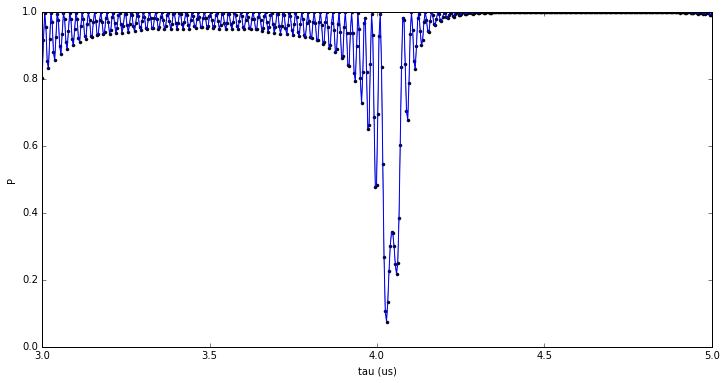

In [21]:
%matplotlib inline
fig,ax = analysis.initialize_data_plot(figsize = (12,6), xlims = [3,5], ylims = [0,1])
ax.set_xlabel('tau (us)')
ax.set_ylabel('P')
analytical_P = .5 * (1+analysis.calc_M_single(A, B, 64, omega_larmor, tau))
ax.plot(tau * 1e6, P, '.-k', lw=0.4)
ax.plot(tau * 1e6, analytical_P)
plt.show()

In [22]:
displayed_inds = np.where(np.logical_and(tau>=3*1e-6, tau<=5*1e-6))[0]
res_ind = displayed_inds[np.argmin(analytical_P[displayed_inds])]
t_step = tau[100]-tau[99]
print tau[res_ind], analytical_P[res_ind]

4.02843694842e-06 0.0752372823445


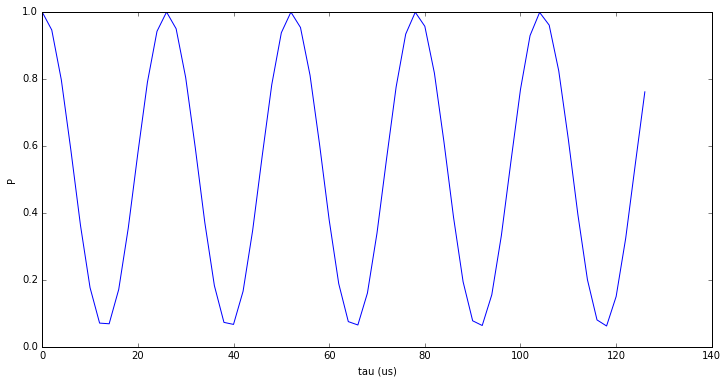

In [23]:
%matplotlib inline
fig,ax = analysis.initialize_data_plot(figsize = (12,6), ylims = [0,1])
ax.set_xlabel('tau (us)')
ax.set_ylabel('P')
N_vals = np.arange(0,128,2)
analytical_P = .5 * (1+analysis.calc_M_single(A, B, N_vals, omega_larmor, tau[res_ind]))
ax.plot(N_vals, analytical_P)
plt.show()

In [24]:
res_N = N_vals[np.argmin(analytical_P[:15])]
print res_N, analytical_P[res_N/2]

14 0.0687611336389


### NV in 0, C13 rotates starting in +x

In [25]:
speed = 12
num_pts = 2 * res_ind * res_N / speed
print num_pts, res_ind, res_N, speed, res_ind % speed
U = (-1j * t_step * speed * H).expm()

644 276 14 12 0


In [45]:
rho_init = qt.tensor(qt.ket2dm(S0), .5 * (Ii + qt.sigmax()))
rho = rho_init
rho_s, rho_c = [rho.ptrace(0)], [rho.ptrace(1)]
for ind in range(num_pts):
    rho = U * rho * U.dag()
    rho_s.append(rho.ptrace(0))
    rho_c.append(rho.ptrace(1))

In [ ]:
movie_dir = 'movie_NV0_Cpx'
for ind in range(len(rho_s)):
    b = qt.Bloch()
    b.add_states(rho_c[ind], kind='vector')
    b.add_states(rho_s[ind], kind='vector')
    b.save(dirc=movie_dir+'/tmp')
    shutil.move(movie_dir+'/tmp/bloch_0.png', movie_dir+'/bloch_' + str(ind) + '.png')    

Code for making a movie: ffmpeg -framerate 15 -i bloch_%01d.png -c:v libx264 -r 30 -pix_fmt yuv420p bloch.mp4

### NV in 1, C13 rotates starting in +x

In [ ]:
rho_init = qt.tensor(qt.ket2dm(S1), .5 * (Ii + qt.sigmax()))
rho = rho_init
rho_s, rho_c = [rho.ptrace(0)], [rho.ptrace(1)]
for ind in range(num_pts):
    rho = U * rho * U.dag()
    rho_s.append(rho.ptrace(0))
    rho_c.append(rho.ptrace(1))

In [ ]:
movie_dir = 'movie_NV1_Cpx'
for ind in range(len(rho_s)):
    b = qt.Bloch()
    b.add_states(rho_c[ind], kind='vector')
    b.add_states(rho_s[ind], kind='vector')
    b.save(dirc=movie_dir+'/tmp')
    shutil.move(movie_dir+'/tmp/bloch_0.png', movie_dir+'/bloch_' + str(ind) + '.png')    

### Dynamical decoupling NV starts in 0, C13 rotates starting in +x

In [ ]:
rho_init = qt.tensor(qt.ket2dm(S0), .5 * (Ii + qt.sigmax()))
rho = rho_init
rho_s, rho_c = [rho.ptrace(0)], [rho.ptrace(1)]
for ind in range(num_pts):
    if ind % (res_ind/speed) == 0:
        UorP = pi_pulse
    else:
        UorP = U
    rho = UorP * rho * UorP.dag()
    rho_s.append(rho.ptrace(0))
    rho_c.append(rho.ptrace(1))

In [ ]:
movie_dir = 'movie_dd_NV0_Cpx'
for ind in range(len(rho_s)):
    b = qt.Bloch()
    b.add_states(rho_c[ind], kind='vector')
    b.add_states(rho_s[ind], kind='vector')
    b.save(dirc=movie_dir+'/tmp')
    shutil.move(movie_dir+'/tmp/bloch_0.png', movie_dir+'/bloch_' + str(ind) + '.png')    

### Dynamical decoupling NV starts in 1, C13 rotates starting in +x

In [ ]:
rho_init = qt.tensor(qt.ket2dm(S1), .5 * (Ii + qt.sigmax()))
rho = rho_init
rho_s, rho_c = [rho.ptrace(0)], [rho.ptrace(1)]
for ind in range(num_pts):
    if ind % (res_ind/speed) == 0:
        UorP = pi_pulse
    else:
        UorP = U
    rho = UorP * rho * UorP.dag()
    rho_s.append(rho.ptrace(0))
    rho_c.append(rho.ptrace(1))

In [ ]:
movie_dir = 'movie_dd_NV1_Cpx'
for ind in range(len(rho_s)):
    b = qt.Bloch()
    b.add_states(rho_c[ind], kind='vector')
    b.add_states(rho_s[ind], kind='vector')
    b.save(dirc=movie_dir+'/tmp')
    shutil.move(movie_dir+'/tmp/bloch_0.png', movie_dir+'/bloch_' + str(ind) + '.png')    

### Dynamical decoupling NV starts in +x, C13 rotates starting in +x

In [39]:
rho_init = qt.tensor(qt.ket2dm((S0 + S1).unit()), .5 * Ii)
rho = rho_init
rho_s, rho_c = [rho.ptrace(0)], [rho.ptrace(1)]
P = []
counter = 0
first_pulse = True
for ind in range(num_pts):
    if (first_pulse and counter == (res_ind/speed)) or ((not first_pulse) and counter == 2 * (res_ind/speed)):
        UorP = pi_pulse
        #print "pulse ", counter, res_ind/speed
        counter = 0
        first_pulse = False
    else:
        UorP = U
        counter += 1
    rho = UorP * rho * UorP.dag()
    rho_s.append(rho.ptrace(0))
    rho_c.append(rho.ptrace(1))
print (2 * rho_init * rho).tr().real

0.971116038971


KeyboardInterrupt: 

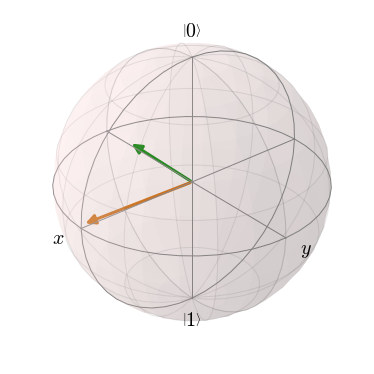

In [31]:
movie_dir = 'movie_dd_NVx_Cpx'
for ind in range(len(rho_s)):
    b = qt.Bloch()
    b.view = [-40,30]
    b.add_states(rho_c[ind], kind='vector')
    b.add_states(rho_s[ind], kind='vector')
    b.save(dirc=movie_dir+'/tmp')
    shutil.move(movie_dir+'/tmp/bloch_0.png', movie_dir+'/bloch_' + str(ind) + '.png')    

### Let's try the way I know works

In [ ]:
rho_init = qt.tensor(qt.ket2dm((S0 + S1).unit()), .5 * Ii)
for ind in range(len(tau)):
    t = tau[ind]
    U_tau = (-1j * t * H).expm()
    U = (U_tau * pi_pulse * U_tau) ** N
    rho_final = U * rho_init * U.dag()
    P[ind] = (2 * rho_init * rho_final).tr().real
M = 2 * P - 1

In [34]:
speed = 12
num_pts = 2 * res_ind * res_N / speed
print num_pts, res_ind, res_N, speed, res_ind % speed
U = (-1j * t_step * speed * H).expm() 

rho_init = qt.tensor(qt.ket2dm(S0), .5 * (Ii + qt.sigmax()))
rho = rho_init
rho_s, rho_c = [rho.ptrace(0)], [rho.ptrace(1)]
rotation_vector = [[0,0,-1]] 
counter = 0
first_pulse = True
s_up = True
omega_tilde = np.sqrt((A + omega_larmor) ** 2 + B ** 2)
for ind in range(num_pts):
	if (first_pulse and counter == (res_ind/speed)) or ((not first_pulse) and counter == 2 * (res_ind/speed)):
		UorP = pi_pulse
		print "pulse ", counter, res_ind/speed
		counter = 0
		first_pulse = False
		s_up = not s_up
	else:
		UorP = U
		counter += 1
	rho = UorP * rho * UorP.dag()
	rho_s.append(rho.ptrace(0))
	rho_c.append(rho.ptrace(1))
	if s_up:
		rotation_vector.append([0,0,-1])
	else:
		rotation_vector.append([B/omega_tilde, 0, (A+omega_larmor)/omega_tilde])

644 276 14 12 0
pulse  23 23
pulse  46 23
pulse  46 23
pulse  46 23
pulse  46 23
pulse  46 23
pulse  46 23
pulse  46 23
pulse  46 23
pulse  46 23
pulse  46 23
pulse  46 23
pulse  46 23
pulse  46 23


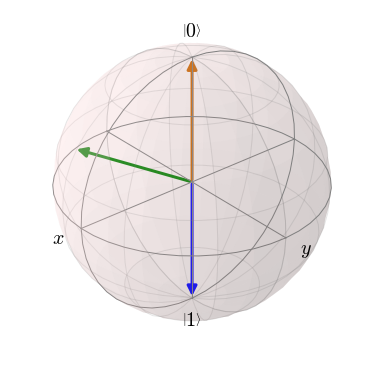

In [36]:
movie_dir = 'movie_dd_NV0_Cpx'
for ind in [10]:#range(len(rho_s)):
    b = qt.Bloch()
    b.view = [-40,30]
    b.add_states(rho_c[ind], kind='vector')
    b.add_states(rho_s[ind], kind='vector')
    b.add_vectors(rotation_vector[ind])
    b.show()
    #b.save(dirc=movie_dir+'/tmp')
    #shutil.move(movie_dir+'/tmp/bloch_0.png', movie_dir+'/bloch_' + str(ind) + '.png')